## Gathering the data -- using Google BigQuery

Process:
    
1. create a project and project dataset in BigQuery
2. Query big data (see three used in this project queries below)
3. save/copy the query results into a table
4. export the dataset table into a csv file

-- QUERY 1
-- What is the most common factor in a motor vehicle collision in Brooklyn? 
-- This query counts the number of collisions for each collision type, in descending order.

SELECT
  contributing_factor_vehicle_1 AS collision_factor,
  COUNT(*) num_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  contributing_factor_vehicle_1 != "Unspecified"
  AND contributing_factor_vehicle_1 != ""
  AND borough = "BROOKLYN"
  AND cast(timestamp as date) between "2014-01-01" AND "2017-12-31"
GROUP BY
  1
ORDER BY
  num_collisions DESC

-- QUERY 2
-- What are the most dangerous streets for motor vehicle collisions in Brooklyn? 
-- This query counts the number of fatalities and injured by streets. 
#standardSQL
SELECT
  on_street_name,
  SUM(number_of_persons_killed) AS deaths,
  SUM(number_of_persons_injured) AS injuries
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  on_street_name <> ''
  AND borough = "BROOKLYN"
  AND cast(timestamp as date) between "2014-01-01" AND "2017-12-31"
GROUP BY
  on_street_name
ORDER BY
  deaths DESC
LIMIT
  10


-- QUERY 3
-- What is the most common factor in a motor vehicle collision in NYC's Brooklyn? and what other details can we garner from Brooklyn incidents when looking at primary collision factors? 
-- This query counts the number of fatalities by streets. 


-- check for weird spelling of Brooklyn
#standardSQL
SELECT
  DISTINCT(borough)
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`

SELECT
  *
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough = "BROOKLYN"
  AND cast(timestamp as date) between "2014-01-01" AND "2017-12-31"

In [3]:
%matplotlib inline
import os
from google.cloud import bigquery

#please refer to https://cloud.google.com/bigquery/docs/use-service-accounts to obtain your CREDENTIALS 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'linkedininsightscase-9ef4c28fb738.json'

In [4]:
client = bigquery.Client()

In [5]:
sql = """
SELECT *
FROM `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`
WHERE borough = "BROOKLYN"
AND cast(timestamp as date) between "2014-01-01" AND "2017-12-31"
ORDER BY timestamp ASC
"""

#pct_overlap_terms_by_days_apart.head()

In [6]:
query_job = client.query(sql).to_dataframe()
query_job.to_csv('bigquery_nypd_collisions.csv')

### Loading

In [15]:

## Loading in packages
import csv
import pandas as pd
import numpy as np #import the stats library from numpy
from scipy import stats
from datetime import datetime

#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from collections import defaultdict

import seaborn as sns

import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [8]:
## read the csv pulled from the database
brooklyn_data = pd.read_csv('bigquery_nypd_collisions.csv')
brooklyn_data = brooklyn_data.applymap(lambda x: x.strip() if isinstance(x, str) else x) ## trim up white space across the datatable 

### Exploratory


In [9]:
brooklyn_data.head()

,Unnamed: 0,borough,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,cross_street_name,timestamp,latitude,...,number_of_persons_killed,off_street_name,on_street_name,unique_key,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,zip_code
0,0,BROOKLYN,Physical Disability,Unspecified,NaN,NaN,NaN,HOYT STREET,2014-01-01 00:20:00,40.689019,...,0,NaN,SCHERMERHORN STREET,191162,PASSENGER VEHICLE,UNKNOWN,NaN,NaN,NaN,11201.0
1,1,BROOKLYN,Unspecified,Unspecified,NaN,NaN,NaN,SAINT JOHN'S PLACE,2014-01-01 00:30:00,40.671638,...,0,NaN,NOSTRAND AVENUE,175433,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,11216.0
2,2,BROOKLYN,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,NEWPORT STREET,2014-01-01 00:30:00,40.660179,...,0,NaN,CHRISTOPHER AVENUE,163031,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,11212.0
3,3,BROOKLYN,Unspecified,Unspecified,NaN,NaN,NaN,14 AVENUE,2014-01-01 00:42:00,40.640417,...,0,NaN,37 STREET,134411,VAN,UNKNOWN,NaN,NaN,NaN,11218.0
4,4,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,NaN,6 AVENUE,2014-01-01 00:45:00,40.625084,...,0,NaN,79 STREET,144213,PASSENGER VEHICLE,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,UNKNOWN,NaN,11209.0


In [10]:
brooklyn_data['timestamp'] = pd.to_datetime(brooklyn_data['timestamp'])
brooklyn_data['hour'] = brooklyn_data['timestamp'].dt.hour
brooklyn_data['month'] = brooklyn_data['timestamp'].dt.month
brooklyn_data['weekday'] = brooklyn_data['timestamp'].dt.day_of_week + 1#The day of the week with Monday=1, Sunday=7


Explore when the accidents happen during the day, maybe it is during the evening with low visibility?

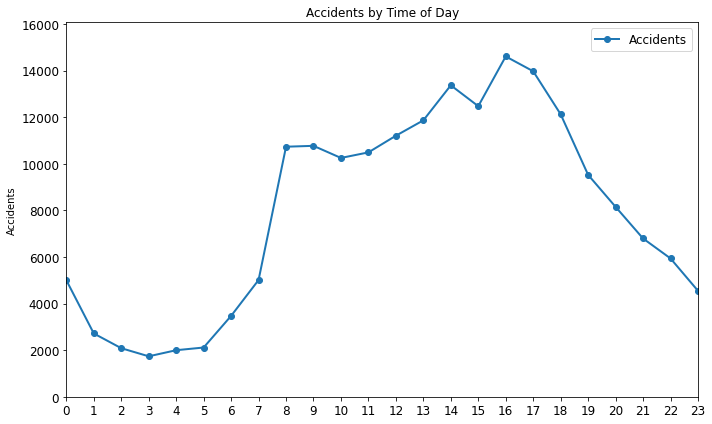

In [11]:


# Count the frequency of accidents for each hour
hour_freq = brooklyn_data['hour'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(hour_freq.index, hour_freq.values, marker='o', linestyle='-', color='#1f77b4', linewidth=2)

# Set the x-axis labels
plt.xticks(hour_freq.index, fontsize = 12)
plt.xlim(0, max(hour_freq.index))

# Set the y-axis label
plt.ylabel('Accidents')
plt.yticks(fontsize=12)
plt.ylim(0, max(hour_freq.values) * 1.1)  # Set the y-axis limit

# Add a legend
plt.legend(['Accidents'], fontsize=12)

# Set the title
plt.title('Accidents by Time of Day')

# Display the plot
plt.tight_layout()
plt.show()


#### Insight 1: The accidents happen during business hours mostly from 8AM to 6pm. 

Now we want to see if there is a seasonal affect to this, maybe there is more accidents in Winter months?

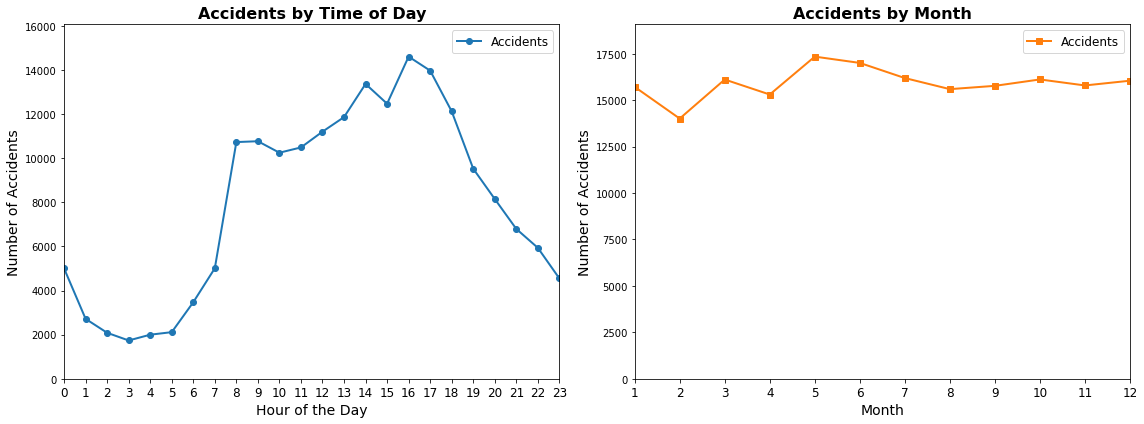

In [12]:


# Count the frequency of accidents for each hour
month_freq = brooklyn_data['month'].value_counts().sort_index()

# Create the plot
hour_freq = brooklyn_data['hour'].value_counts().sort_index()
month_freq = brooklyn_data['month'].value_counts().sort_index()

# Create a single plot
hour_freq = brooklyn_data['hour'].value_counts().sort_index()
month_freq = brooklyn_data['month'].value_counts().sort_index()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot accidents by hour
ax1.plot(hour_freq.index, hour_freq.values, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
ax1.set_xticks(range(0, 24))
ax1.set_xticklabels(range(0, 24), fontsize=12)
ax1.set_xlim(0, max(hour_freq.index))
ax1.set_xlabel('Hour of the Day', fontsize=14)
ax1.set_ylabel('Number of Accidents', fontsize=14)
ax1.set_ylim(0, max(hour_freq.values)*1.1)
ax1.set_title('Accidents by Time of Day', fontsize=16, fontweight='bold')
ax1.legend(['Accidents'], fontsize=12)

# Plot accidents by month
ax2.plot(month_freq.index, month_freq.values, marker='s', linestyle='-', color='#ff7f0e', linewidth=2)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(range(1, 13), fontsize=12)
ax2.set_xlim(1, max(month_freq.index))
ax2.set_xlabel('Month', fontsize=14)
ax2.set_ylim(0, max(month_freq.values)* 1.1)
ax2.set_ylabel('Number of Accidents', fontsize=14)
ax2.set_title('Accidents by Month', fontsize=16, fontweight='bold')
ax2.legend(['Accidents'], fontsize=12)
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


#### Insight 2: There is limited season effect to this.

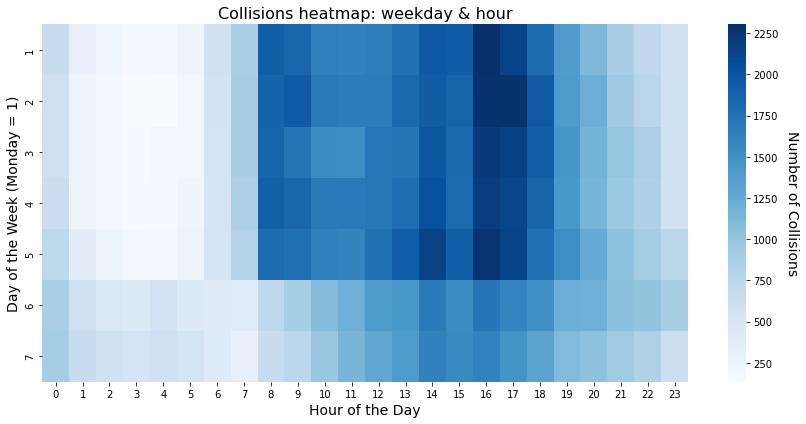

In [17]:
#heatmap of month and dayofthemonth
dayHour = brooklyn_data.groupby(by=['weekday', 'hour']).size().unstack()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Set the title
ax.set_title('Collisions heatmap: weekday & hour', fontsize=16)

# Create the heatmap
heatmap = sns.heatmap(dayHour, cmap='Blues', ax=ax)

# Rename the axes
heatmap.set_xlabel('Hour of the Day', fontsize=14)
heatmap.set_ylabel('Day of the Week (Monday = 1)', fontsize=14)

# Add a colorbar legend
cbar = ax.collections[0].colorbar
cbar.set_label('Number of Collisions', labelpad = 20, fontsize=14, rotation = 270)


##plt.figure(figsize=(12, 6))
#plt.title('Collisions heatmap: weekday & hour')
#sns.heatmap(dayHour, cmap='viridis')
plt.tight_layout()
plt.show()


#### Insight 3: Looking closer. Most collisions happen between 8AM and peak at 6PM from Monday to Friday. 

In [18]:
brooklyn_data.dtypes

Unnamed: 0                                int64
borough                                  object
contributing_factor_vehicle_1            object
contributing_factor_vehicle_2            object
contributing_factor_vehicle_3            object
contributing_factor_vehicle_4            object
contributing_factor_vehicle_5            object
cross_street_name                        object
timestamp                        datetime64[ns]
latitude                                float64
longitude                               float64
location                                 object
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured                 int64
number_of_persons_killed                  int64
off_street_name                         

Driver Inattention/Distraction    28037
Failure to Yield Right-of-Way     12407
Backing Unsafely                   7976
Fatigued/Drowsy                    5292
Following Too Closely              5161
Other Vehicular                    4387
Passing Too Closely                4182
Turning Improperly                 3782
Name: contributing_factor_vehicle_1, dtype: int64


C:\Users\Hoang\AppData\Local\Temp/ipykernel_22676/1639167762.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(factor_freq.index, rotation=25, ha='right', fontsize=12)


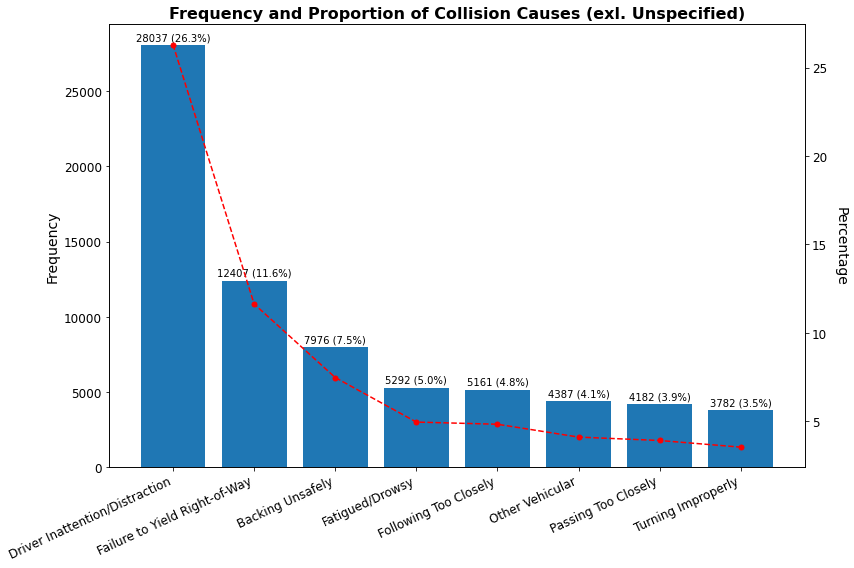

In [45]:
factor_clean = brooklyn_data.loc[brooklyn_data["contributing_factor_vehicle_1"] != "Unspecified", "contributing_factor_vehicle_1"].value_counts()
total_counts = factor_clean.sum()
factor_freq = brooklyn_data.loc[brooklyn_data["contributing_factor_vehicle_1"] != "Unspecified", "contributing_factor_vehicle_1"].value_counts().head(8)

print(factor_freq)

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the histogram on the first y-axis
bars = ax1.bar(factor_freq.index, factor_freq.values, color='#1f77b4')
ax1.set_xticklabels(factor_freq.index, rotation=25, ha='right', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the percentage on the second y-axis
ax2.plot(factor_freq.index, (factor_freq / total_counts) * 100, 'r--', marker='o', markersize=5)
ax2.set_ylabel('Percentage', fontsize=14, rotation = 270, labelpad = 20)
ax2.tick_params(axis='y', labelsize=12)

# Set the title
ax1.set_title('Frequency and Proportion of Collision Causes (exl. Unspecified)', fontsize=16, fontweight='bold')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    proportion = (height / total_counts) * 100  # Calculate the proportion to total
    ax1.annotate('{:.0f} ({:.1f}%)'.format(height, proportion),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')  

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

#### Insight 4: Driver inattention/ distraction is the biggest cause of 

ATLANTIC AVENUE        5311
FLATBUSH AVENUE        3588
LINDEN BOULEVARD       2435
NOSTRAND AVENUE        2421
BEDFORD AVENUE         2247
OCEAN PARKWAY          2198
EASTERN PARKWAY        2190
UTICA AVENUE           2012
CONEY ISLAND AVENUE    1892
KINGS HIGHWAY          1858
PENNSYLVANIA AVENUE    1779
FULTON STREET          1778
4 AVENUE               1643
3 AVENUE               1636
OCEAN AVENUE           1620
Name: on_street_name, dtype: int64


C:\Users\Hoang\AppData\Local\Temp/ipykernel_22676/594542479.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(street_factor.index, rotation=45, ha='right', fontsize=12)


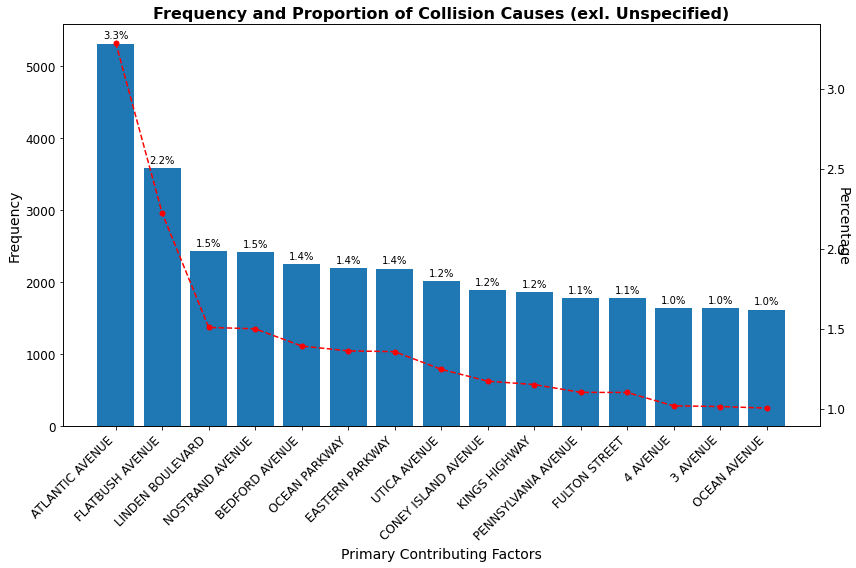

In [22]:
# Now we want to figure out where does these accidents happen the most
street_factor_all = brooklyn_data["on_street_name"].value_counts()
totalStreetCounts = street_factor_all.sum()
street_factor = brooklyn_data["on_street_name"].value_counts().head(15)
print(street_factor)

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the histogram on the first y-axis
street_bars = ax1.bar(street_factor.index, street_factor.values, color='#1f77b4')
ax1.set_xlabel('Primary Contributing Factors', fontsize=14)
ax1.set_xticklabels(street_factor.index, rotation=45, ha='right', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the percentage on the second y-axis
ax2.plot(street_factor.index, (street_factor / totalStreetCounts) * 100, 'r--', marker='o', markersize=5)
ax2.set_ylabel('Percentage', fontsize=14, rotation = 270)
ax2.tick_params(axis='y', labelsize=12)

# Set the title
ax1.set_title('Frequency and Proportion of Collision Causes (exl. Unspecified)', fontsize=16, fontweight='bold')

# Add value labels on top of bars
for bar in street_bars:
    height = bar.get_height()
    proportion = (height / totalStreetCounts) * 100  # Calculate the proportion to total
    ax1.annotate('{:.1f}%'.format(proportion),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')  

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

#### Insight 5: The top 3 streets (Atlantic, Flatbush, and Linden) are among the biggest streets coming out of New York and through Brooklyn.




Now we want to understand the impact of these accidents in terms of injuries and deaths

In [23]:
total_accidents = len(brooklyn_data)
print(f"Total number of accidents: {total_accidents}")

Total number of accidents: 190984


In [24]:
## Calculate the number of accidents involving motorist injuries or deaths:
motorist_injuries = len(brooklyn_data[brooklyn_data['number_of_motorist_injured'] > 0])
motorist_deaths = len(brooklyn_data[brooklyn_data['number_of_motorist_killed'] > 0])
motorist_accidents = len(brooklyn_data[(brooklyn_data['number_of_motorist_injured'] > 0) | (brooklyn_data['number_of_motorist_killed'] > 0)])
print(f"Number of accidents involving motorist injuries: {motorist_injuries}")
print(f"Number of accidents involving motorist deaths: {motorist_deaths}")
print(f"Number of accidents involving motorist injuries or deaths: {motorist_accidents}")

Number of accidents involving motorist injuries: 22579
Number of accidents involving motorist deaths: 57
Number of accidents involving motorist injuries or deaths: 22608


In [25]:
## Calculate the number of accidents involving motorist injuries or deaths:
bicyclist_injuries = len(brooklyn_data[brooklyn_data['number_of_cyclist_injured'] > 0])
bicyclist_deaths = len(brooklyn_data[brooklyn_data['number_of_cyclist_killed'] > 0])
bicyclist_accidents = len(brooklyn_data[(brooklyn_data['number_of_cyclist_injured'] > 0) | (brooklyn_data['number_of_cyclist_killed'] > 0)])
print(f"Number of accidents involving bicyclist injuries: {bicyclist_injuries}")
print(f"Number of accidents involving bicyclist deaths: {bicyclist_deaths}")
print(f"Number of accidents involving bicyclist injuries or deaths: {bicyclist_accidents}")

Number of accidents involving bicyclist injuries: 5633
Number of accidents involving bicyclist deaths: 21
Number of accidents involving bicyclist injuries or deaths: 5653


In [26]:
## Calculate the number of accidents involving pedestrian injuries or deaths:
pedestrian_injuries = len(brooklyn_data[brooklyn_data['number_of_pedestrians_injured'] > 0])
pedestrian_deaths = len(brooklyn_data[brooklyn_data['number_of_pedestrians_killed'] > 0])
pedestrian_accidents = len(brooklyn_data[(brooklyn_data['number_of_pedestrians_injured'] > 0) | (brooklyn_data['number_of_pedestrians_killed'] > 0)])
print(f"Number of accidents involving pedestrian injuries: {pedestrian_injuries}")
print(f"Number of accidents involving pedestrian deaths: {pedestrian_deaths}")
print(f"Number of accidents involving pedestrian injuries or deaths: {pedestrian_accidents}")


total_injury_accidents = len(brooklyn_data[(brooklyn_data['number_of_persons_injured'] > 0) | (brooklyn_data['number_of_persons_killed'] > 0)])
print(f"Total number of accidents involving injuries or deaths: {total_injury_accidents}")


Number of accidents involving pedestrian injuries: 11420
Number of accidents involving pedestrian deaths: 127
Number of accidents involving pedestrian injuries or deaths: 11541
Total number of accidents involving injuries or deaths: 39582


In [27]:
## calculate the percentage of accidents
motorist_accident_percentage = (motorist_accidents / total_accidents) * 100
print(f"Percentage of accidents involving motorist injuries or deaths: {motorist_accident_percentage:.2f}%")

bicyclist_accident_percentage = (bicyclist_accidents / total_accidents) * 100
print(f"Percentage of accidents involving bicyclist injuries or deaths: {bicyclist_accident_percentage:.2f}%")

pedestrian_accident_percentage = (pedestrian_accidents / total_accidents) * 100
print(f"Percentage of accidents involving pedestrians injuries or deaths: {pedestrian_accident_percentage:.2f}%")


Percentage of accidents involving motorist injuries or deaths: 11.84%
Percentage of accidents involving bicyclist injuries or deaths: 2.96%
Percentage of accidents involving pedestrians injuries or deaths: 6.04%


In [33]:
# Function to determine if the accident occurred during business hours
def is_business_hour(timestamp):
    hour = timestamp.hour
    if 8 <= hour < 18:
        return "Yes"
    else:
        return "No"

# Apply the function to create the 'business_hour' column
brooklyn_data['business_hour'] = brooklyn_data['timestamp'].apply(is_business_hour)

In [34]:
def is_weekend(timestamp):
    day_of_week = timestamp.dayofweek
    if day_of_week == 5 or day_of_week == 6:
        return "Yes"
    else:
        return "No"

# Apply the function to create the 'weekend' column
brooklyn_data['weekend'] = brooklyn_data['timestamp'].apply(is_weekend)

### Conclusion: The majority of the accidents are happening during the peak traffic hours during the weekday and along some of the biggest streets in Brooklyn coming out of and into New York. The context is that the traffic congestion makes drivers become both impatient and fatique behind the wheels, influencing them into making bad decisions and, in turn, getting into preventable accidents. 

In [35]:
# Export the brooklyn_data DataFrame to a new CSV file
output_file = 'brooklyn_data_processed.csv'
brooklyn_data.to_csv(output_file, index=False)
print(f"Data exported to {output_file} successfully.")

Data exported to brooklyn_data_processed.csv successfully.
